# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import scipy.stats as st
import emcee
import george

%matplotlib inline
from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab


Bad key "text.kerning_factor" on line 4 in
C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


<Table length=14588>
       time             flux             error        quarter
     float64          float64           float64        int32 
----------------- ---------------- ------------------ -------
539.4710179205795 5221.16455078125  4.891251087188721       6
539.4914521464307 5216.07958984375  4.892819404602051       6
539.5118864718097    5225.43359375  4.891888618469238       6
539.5323205971945   5233.111328125  4.892074108123779       6
539.5527548221144 5221.17333984375  4.891964435577393       6
 539.573189147035 5220.09521484375  4.891523361206055       6
539.5936232714812 5222.14208984375  4.893854141235352       6
539.6140574957026 5224.57958984375  4.893648147583008       6
539.6344918194518 5223.78564453125  4.894421100616455       6
539.6549259432068 5231.61669921875  4.894259929656982       6
              ...              ...                ...     ...
905.7431114583233 5863.63427734375  4.119894027709961       9
905.7635458554214  5867.2041015625 4.1199517250061035       9
905.7839800525107   5867.841796875  4.119955539703369       9
905.8044143491425 5862.43798828125  4.119598388671875       9
 905.824848745775 5863.95458984375  4.118742942810059       9
 905.845282941933   5870.349609375  4.119640827178955       9
 905.865717337867 5867.27099609375  4.119102478027344       9
905.8861516335674 5868.67822265625  4.119019031524658       9
905.9065858290269   5864.173828125  4.119871616363525       9
905.9270202242624 5861.61572265625  4.119407653808594       9

In [2]:
quarter_dict={}
for time,quarter in zip(tab['time'],tab['quarter']):
    quarter_dict[time]=quarter

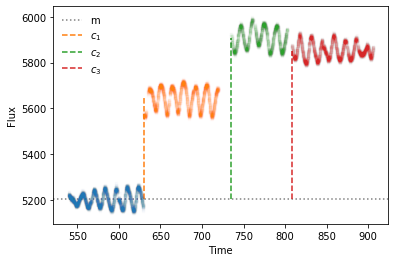

In [3]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [4]:
t=np.array(tab['time'])
y=np.array(tab['flux'])
dy=np.array(tab['error'])

In [5]:
def better_truncnorm(myclip_a,myclip_b,my_mean,my_std):
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return st.truncnorm(a,b,loc=(my_mean),scale=my_std)

In [98]:
#priors
prior_m = st.norm(loc=means[0],scale=30/2)#pretty uninformative

prior_c1 = st.norm(loc=means[1]-means[0],scale=50/2)

prior_c2 = st.norm(loc=means[2]-means[0],scale=50/2)

prior_c3 = st.norm(loc=means[3]-means[0],scale=50/2)

prior_A = st.uniform(loc=1,scale=100) #I litterally have no idea what this is, maybe greater than zero...?

prior_gamma = st.uniform(1e-9,100)#I do not know what this is either

prior_log_p = better_truncnorm(1e-9,50,3.5/50,3) #Must be greater than zero, the period of oscillation in above ~ 3.5/50

prior_lambda = better_truncnorm(1e-6,1000,60,20) #seems like the amplitude of oscillations, ~0 at 0

In [7]:
def random_values():
    init_A = prior_A.rvs(1)[0]
    init_log_p = prior_log_p.rvs(1)[0]
    init_gamma = prior_gamma.rvs(1)[0]
    init_lambda = prior_lambda.rvs(1)[0]

    init_p=np.array([init_A,init_gamma,init_log_p,init_lambda])
    return(init_p)

init_p=random_values()

In [8]:
#something here is not working right
class MEAN_MODEL_GOSH(george.modeling.Model):
    parameter_names=("m","c1","c2","c3")
    
    def get_value(self,t):
        mean_dict = {6:self.m,7:self.m+self.c1,8:self.m+self.c2,9:self.m+self.c3}
        quarter = np.vectorize(quarter_dict.get)(t)
        this = np.vectorize(mean_dict.get)(quarter)
        return(this)
    
    def set_vector(self,p):
        self.m = p[0]
        self.c1 = p[1]
        self.c2 = p[2]
        self.c3 = p[3]

mean_model = MEAN_MODEL_GOSH

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [9]:
k = init_p[0] * george.kernels.ExpSine2Kernel(gamma=init_p[1],log_period=init_p[2])+george.kernels.ExpSquaredKernel(metric=init_p[3])

gp = george.GP(k,mean=mean_model(means[0],means[1]-means[0],means[2]-means[0],means[3]-means[0]))

In [10]:
gp.get_parameter_names()

('mean:m',
 'mean:c1',
 'mean:c2',
 'mean:c3',
 'kernel:k1:k1:log_constant',
 'kernel:k1:k2:gamma',
 'kernel:k1:k2:log_period',
 'kernel:k2:metric:log_M_0_0')

In [11]:
gp.compute(t[::50],dy[::50])

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [105]:
def log_prior(p,test=False):
    gp.set_parameter_vector(p)
    
    p_m = p[0]
    p_c1 = p[1]
    p_c2 = p[2]
    p_c3 = p[3]
    p_A = p[4]
    p_gamma = p[5]
    p_log_period = p[6]
    p_lambda = p[7]
    
    prob=0

    a=np.array([prior_m.pdf(p_m),prior_c1.pdf(p_c1),prior_c2.pdf(p_c2),prior_c3.pdf(p_c3),
                prior_A.pdf(p_A),prior_gamma.pdf(p_gamma),prior_log_p.pdf(p_log_period),prior_lambda.pdf(p_lambda)])

    if np.any((a<=0)):
        if test:
            print(a<=0)
        return(np.inf)
    else:
        prob=np.sum(np.log(a))
        return(prob)


In [16]:
#test code
"""
gp.set_parameter_vector(random_values())
gp.compute(t[::10],dy[::10])
gp.log_likelihood(y[::10])
gp.log_prior()
a = gp.get_parameter_vector()
total_log_prior(a[4::])
gp.set_parameter_vector(random_values())
gp.recompute()
a = gp.get_parameter_vector()
total_log_prior(a[4::])
"""

'\ngp.set_parameter_vector(random_values())\ngp.compute(t[::10],dy[::10])\ngp.log_likelihood(y[::10])\ngp.log_prior()\na = gp.get_parameter_vector()\ntotal_log_prior(a[4::])\ngp.set_parameter_vector(random_values())\ngp.recompute()\na = gp.get_parameter_vector()\ntotal_log_prior(a[4::])\n'

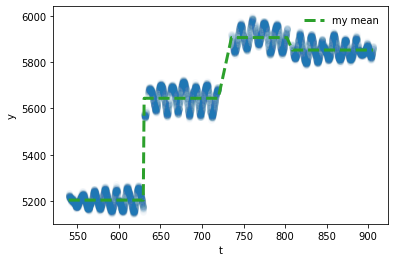

In [13]:
p = gp.get_parameter_vector()
plt.scatter(t, y, color='C0', marker='o',alpha=0.02)
plt.plot(t, MEAN_MODEL_GOSH(p[0],p[1],p[2],p[3]).get_value(t), color='C2', ls='--', label='my mean', lw=3)
plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y');

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [14]:
gp.get_parameter_vector()

array([5.20379938e+03, 4.40027437e+02, 7.02210040e+02, 6.48388347e+02,
       2.75674955e+00, 3.78927095e+00, 4.70448707e+00, 4.54162972e+00])

In [137]:
# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y[::50], quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y[::50], quiet=True)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

In [138]:
results.x

array([5.20395146e+03, 4.34503206e+02, 6.97711246e+02, 6.50018272e+02,
       2.49932925e+01, 1.48055327e+01, 5.14525202e+00, 1.52113502e+00])

In [114]:
test_log_prior(results.x) #gamma of 17

-35.589533223794426

In [115]:
gp.get_parameter_vector()

array([5.20377933e+03, 4.37302483e+02, 6.99125102e+02, 6.45479252e+02,
       5.36469108e+00, 1.79007681e+01, 3.85852834e+00, 1.58848013e+00])

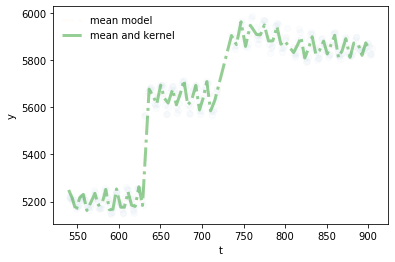

In [72]:
#this kills my laptop

#plot the mean, the model after scipy optimizing it, and the original data
"""
ypred2, cov = gp.predict(y[::50],t, return_cov=True)
std = np.sqrt(np.diag(cov))

# plot the data
plt.scatter(t[::50], y[::50], color='C0', marker='o',alpha=0.02)
#plt.scatter(t[::10], y[::10], color='C3', marker='o', label='The data we used to condition the GP')

# plot our initial prediction with a constant mean
plt.plot(t,MEAN_MODEL_GOSH(p[0],p[1],p[2],p[3]).get_value(t), 'C1', ls='--', label='mean model', lw=3,alpha=0.02)

# plot our new prediction mean and kernel
plt.plot(t[::200], ypred2[::200], 'C2', ls='-.', label='mean and kernel', lw=3,alpha=0.5)

# plot the scatter about the posterior predictive mean from the diagonal of the covariance matrix 
#plt.fill_between(t, ypred2-std, ypred2+std, color='lightgrey')


plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y');
"""

In [53]:
def lnprob(p):
    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    
    logprior = log_prior(p)
    
    if not np.isfinite(logprior):
        return -np.inf
    
    logliklihood = gp.lnlikelihood(y[::50])
        
    return logprior+logliklihood

In [109]:
nwalkers, ndim = 16, 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers,ndim)

log_prior(p0[0,:],test=True)


-35.60438635951728

In [110]:
total_steps=400
print('running the main sample')
sampler.run_mcmc(p0,total_steps)

running the main sample


C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[5.19376701e+03, 4.37152297e+02, 6.98521528e+02, 6.45455066e+02,
         5.49109334e+00, 2.58525851e+01, 4.23474414e+00, 1.73541574e+00],
        [5.21346137e+03, 4.38375044e+02, 7.01073596e+02, 6.47724055e+02,
         5.42349923e+00, 2.56049688e+01, 4.23490130e+00, 1.61891153e+00],
        [5.20931496e+03, 4.38580064e+02, 7.00587930e+02, 6.47309948e+02,
         5.37012075e+00, 2.66990212e+01, 3.72394148e+00, 1.53905778e+00],
        [5.21286236e+03, 4.39123939e+02, 7.01695339e+02, 6.47439232e+02,
         5.13531238e+00, 2.54546379e+01, 4.23426982e+00, 1.63635599e+00],
        [2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
         2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01],
        [5.20539968e+03, 4.37475631e+02, 6.99563031e+02, 6.46894987e+02,
         5.69487590e+00, 2.57306204e+01, 4.23401399e+00, 1.64931749e+00],
        [5.19574565e+03, 4.37153014e+02, 6.98882843e+02, 6.45489346e+02,
         5.50323098e+00, 2.51201254e+01, 4.41

In [111]:
np.shape(sampler.chain)

(16, 400, 8)

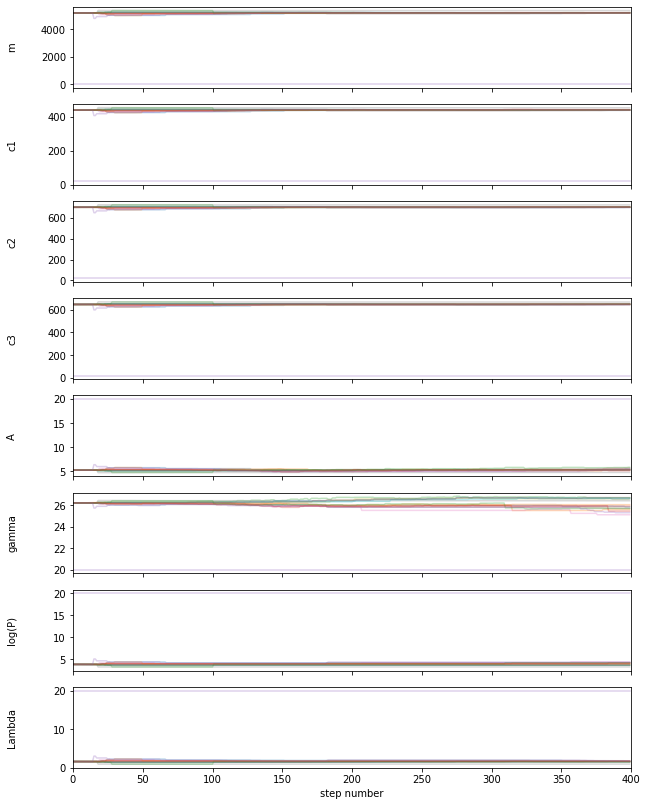

In [112]:
fig, axes = plt.subplots(8, figsize=(10, 14), sharex=True)
samples = sampler.chain
labels = ["m", "c1", "c2", "c3", "A", "gamma", "log(P)", "Lambda"]
for j in range(nwalkers):
    for i in range(ndim):
        ax = axes[i]
        ax.plot(np.arange(0,total_steps),samples[j, :, i], alpha=0.3)
        ax.set_xlim(0,total_steps)
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [84]:
burn_cutoff = 150

In [85]:
no_burn = (sampler.chain)[:,burn_cutoff::,:]
np.shape(no_burn)

(16, 250, 8)

In [86]:
first=(total_steps-burn_cutoff)*nwalkers
burn_flat = no_burn.reshape(first,8)

<h1>Doesn't seem like everything strictly converges<h1>

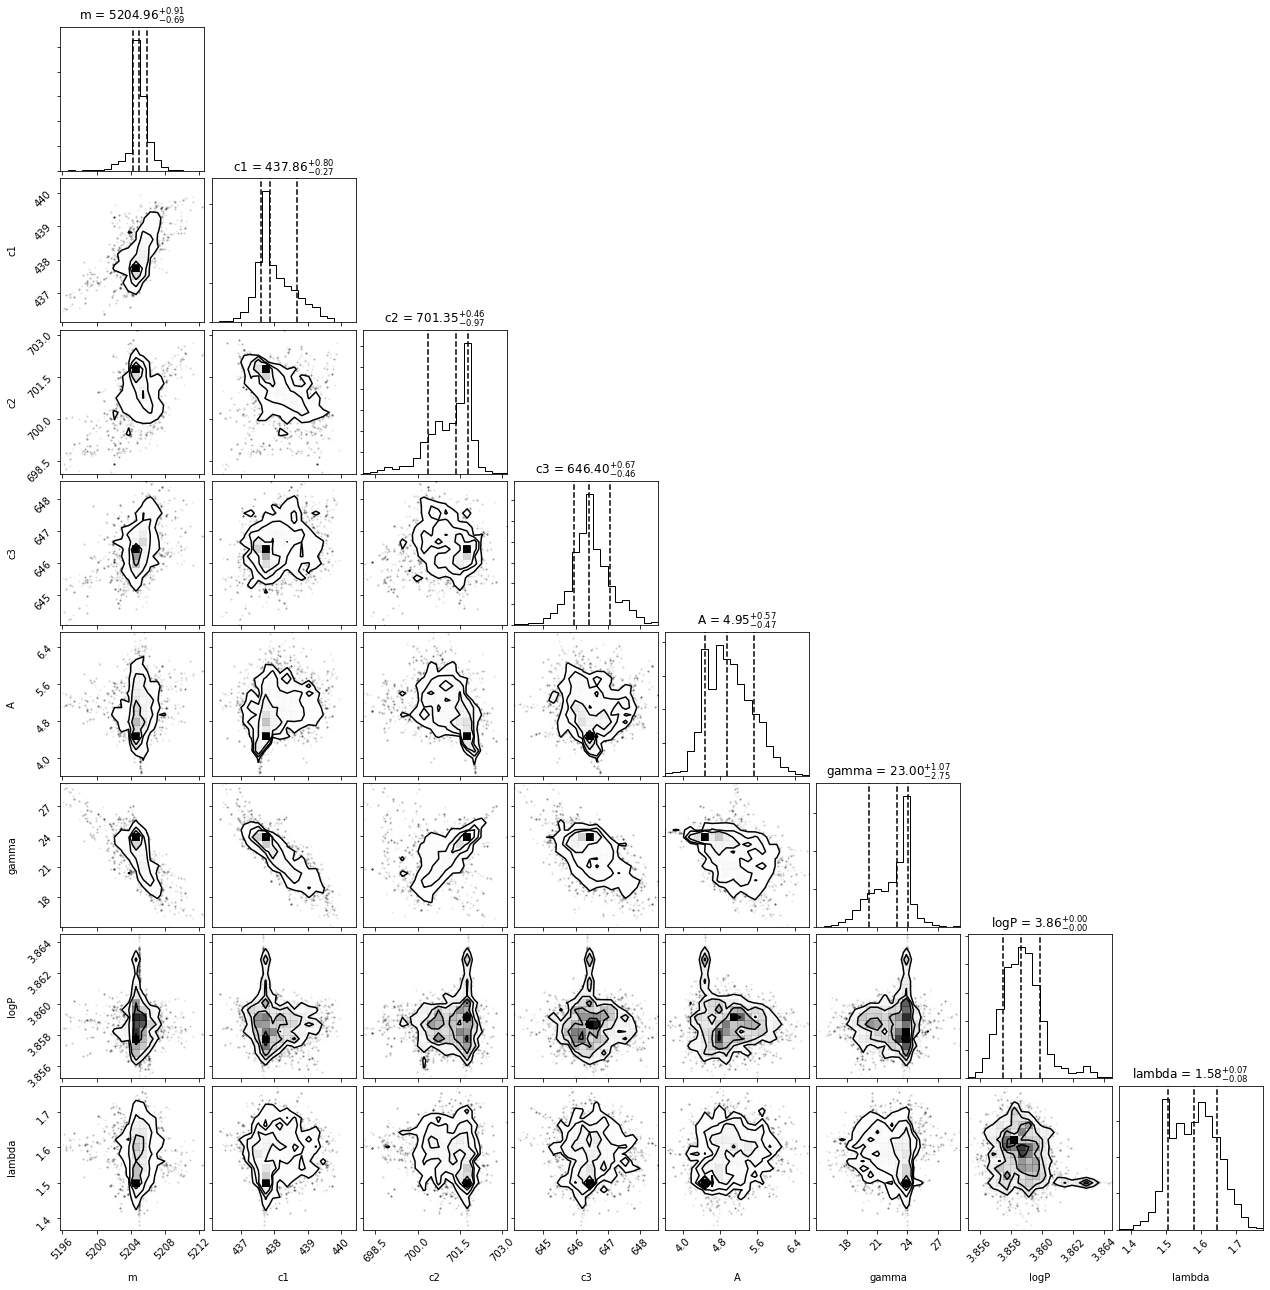

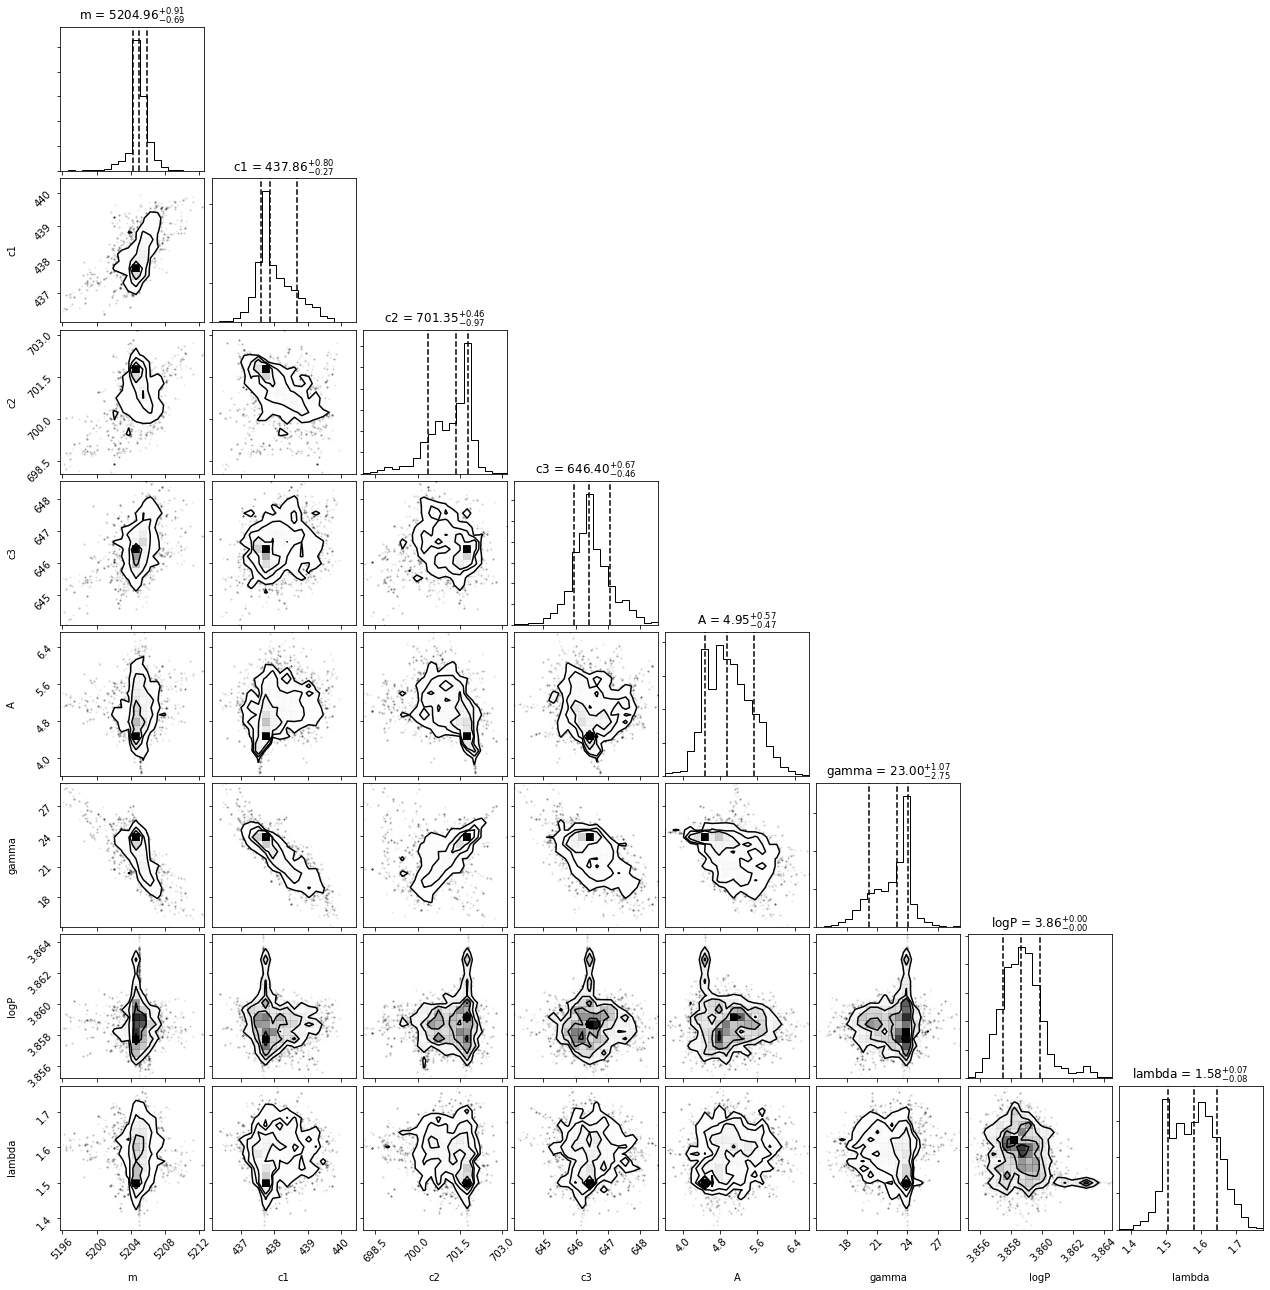

In [62]:
import corner
corner.corner(sampler.flatchain,labels=['m','c1','c2','c3','A','gamma','logP','lambda'],quantiles=[0.16, 0.5, 0.84],show_titles=True)

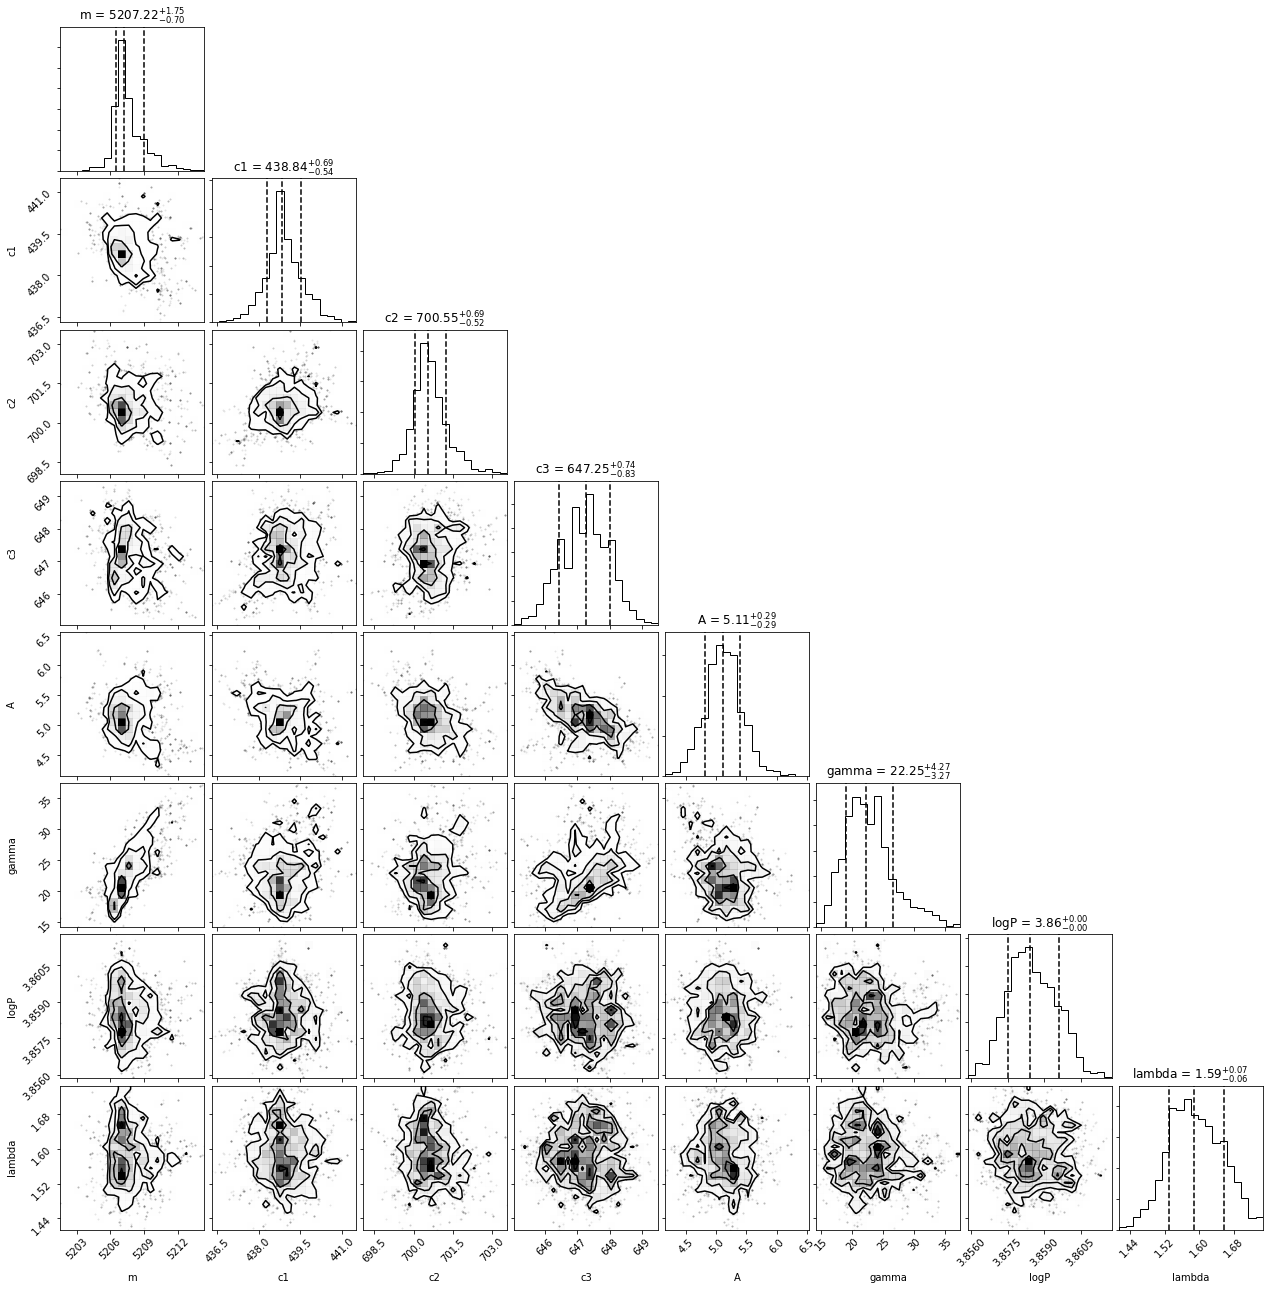

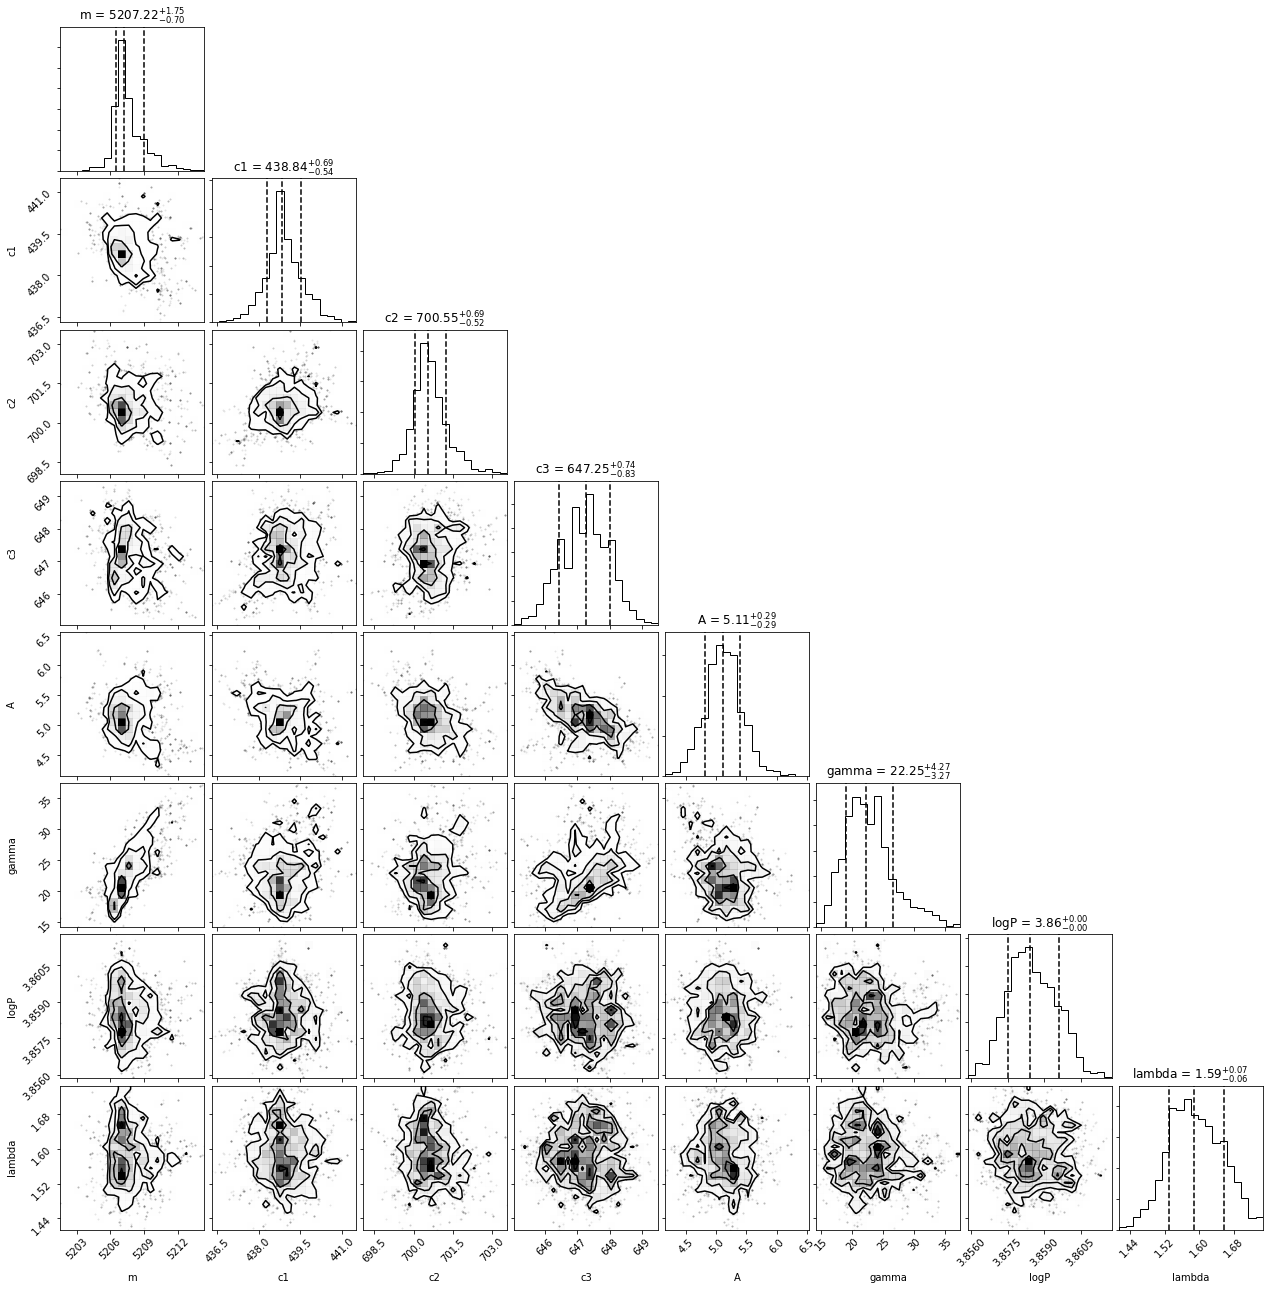

In [87]:
corner.corner(burn_flat,labels=['m','c1','c2','c3','A','gamma','logP','lambda'],quantiles=[0.16, 0.5, 0.84],show_titles=True)

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

Text(0.5, 0, 'time')

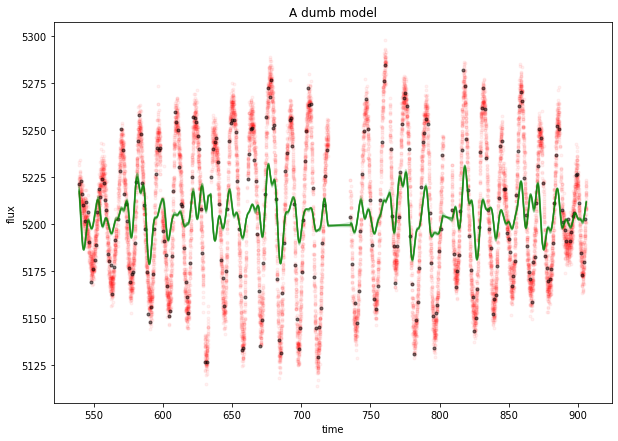

In [216]:
#correct samples; how to estimate
final_c1 = np.median(burn_flat[:,1])
final_c2 = np.median(burn_flat[:,2])
final_c3 = np.median(burn_flat[:,3])
def correct(t,y):
    correction_dict = {6:0,7:final_c1,8:final_c2,9:final_c3}
    quarter = np.vectorize(quarter_dict.get)(t)
    this = np.vectorize(correction_dict.get)(quarter)
    return(y-this)

corrected_y = correct(t,y)

plt.figure(figsize=(10,7))

plt.plot(t, corrected_y, "r.", alpha=0.05,label='all data')
plt.plot(t[::50], corrected_y[::50], "k.",alpha=0.5,label='conditioned data')
#next plot 10 posterior samples
samples = burn_flat
for s in samples[np.random.randint(len(samples), size=10)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y[::50], t, return_cov=False)
    corrected_mu = correct(t,mu)
    plt.plot(t,corrected_mu,color='g',alpha=0.2)    

plt.title('A dumb model')
plt.ylabel('flux')
plt.xlabel('time')

In [139]:
print(results.x)

[5.20395146e+03 4.34503206e+02 6.97711246e+02 6.50018272e+02
 2.49932925e+01 1.48055327e+01 5.14525202e+00 1.52113502e+00]


In [169]:
#reset gp:
gp.set_parameter_vector(results.x)

In [140]:
gp.get_parameter_names()

('mean:m',
 'mean:c1',
 'mean:c2',
 'mean:c3',
 'kernel:k1:k1:log_constant',
 'kernel:k1:k2:gamma',
 'kernel:k1:k2:log_period',
 'kernel:k2:metric:log_M_0_0')

In [183]:
list_res = results.x.tolist()
just_trust_me = np.array(list_res) #neccessary to break up that I want just trust me to be seperate from results.x
just_trust_me[6]=4
gp.set_parameter_vector(just_trust_me)
print(gp.get_parameter_vector())

[5.20395146e+03 4.34503206e+02 6.97711246e+02 6.50018272e+02
 2.49932925e+01 1.48055327e+01 4.00000000e+00 1.52113502e+00]


In [185]:
np.save('hwk7_tuned.npy',just_trust_me)


Text(0.5, 0, 'time')

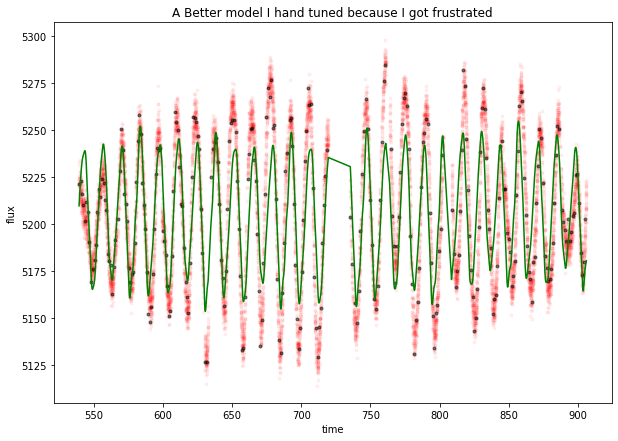

In [219]:
# A controls step size, but also amplitude
#P controls amplitude, but probably in tune with other things because it reacts too strongly to small changes

#this seems like a very fragile model, like a chaotic model: might explain why it doesn't converge well.
gp.set_parameter_vector(np.load('hwk7_tuned.npy'))

plt.figure(figsize=(10,7))

plt.plot(t, corrected_y, "r.", alpha=0.05,label='all data')
plt.plot(t[::50], corrected_y[::50], "k.",alpha=0.5,label='conditioned data')
#next plot 10 posterior samples
samples = burn_flat

mu = gp.predict(y[::50], t, return_cov=False)
corrected_mu = correct(t,mu)
plt.plot(t,corrected_mu,color='g',alpha=1)    

plt.title('A Better model I hand tuned because I got frustrated')
plt.ylabel('flux')
plt.xlabel('time')

In [187]:
#lets take a better final model params and run that through emcee.

nwalkers, ndim = 16, 8
sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

gp.set_parameter_vector(np.load(hwk7_tuned.npy))

p0_2 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers,ndim)

log_prior(p0_2[0,:],test=True)

total_steps=400
print('running the main sample')
sampler_2.run_mcmc(p0_2,total_steps)

running the main sample


(array([[5.19383269e+03, 4.37188335e+02, 7.00550991e+02, 6.46337389e+02,
         1.72207553e+01, 2.25312822e+00, 4.01162170e+00, 1.66534716e+00],
        [5.19252433e+03, 4.36722134e+02, 6.99250827e+02, 6.45281670e+02,
         1.69445418e+01, 2.29974981e+00, 4.01128529e+00, 1.73334028e+00],
        [5.19126294e+03, 4.35895681e+02, 7.00207112e+02, 6.44858217e+02,
         1.64351743e+01, 4.48243329e-01, 4.01089641e+00, 1.83021604e+00],
        [5.19128917e+03, 4.37742364e+02, 7.00943204e+02, 6.45430270e+02,
         1.78528084e+01, 3.48449913e-01, 4.01109692e+00, 1.52248734e+00],
        [5.19382830e+03, 4.36226940e+02, 7.00943330e+02, 6.46364458e+02,
         1.74602973e+01, 1.76049713e+00, 4.01133063e+00, 1.88139055e+00],
        [5.19240815e+03, 4.36733620e+02, 7.02539946e+02, 6.46273112e+02,
         1.93943321e+01, 2.79604671e-01, 4.01102900e+00, 1.78097541e+00],
        [5.19120182e+03, 4.36910391e+02, 7.00136770e+02, 6.44958248e+02,
         1.68678101e+01, 6.20138016e-01, 4.01

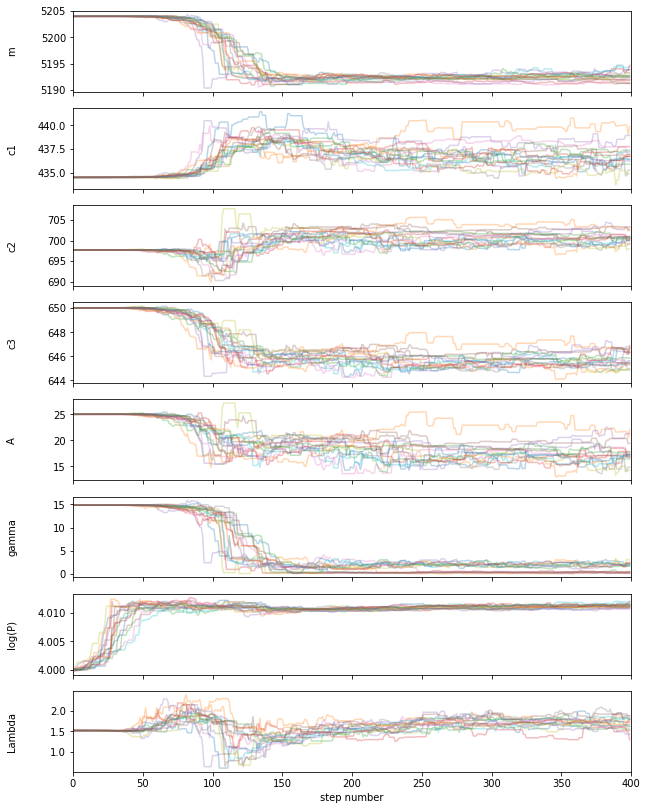

In [196]:
fig, axes = plt.subplots(8, figsize=(10, 14), sharex=True)
samples_2 = sampler_2.chain
labels = ["m", "c1", "c2", "c3", "A", "gamma", "log(P)", "Lambda"]
for j in range(nwalkers):
    for i in range(ndim):
        ax = axes[i]
        ax.plot(np.arange(0,total_steps),samples_2[j, :, i], alpha=0.3)
        ax.set_xlim(0,total_steps)
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [210]:
burn_in_2=150

In [212]:
final_array = np.ones((nwalkers*(total_steps-burn_in_2),8))

for k in range(8):
    for j in range(16):
        final_array[(j)*(total_steps-burn_in_2):(j+1)*(total_steps-burn_in_2),k] = sampler_2.chain[j,burn_in_2::,k]

<h1>Gamma is Bi Modal?</h1>

<h1>Because the posterior draws all look 

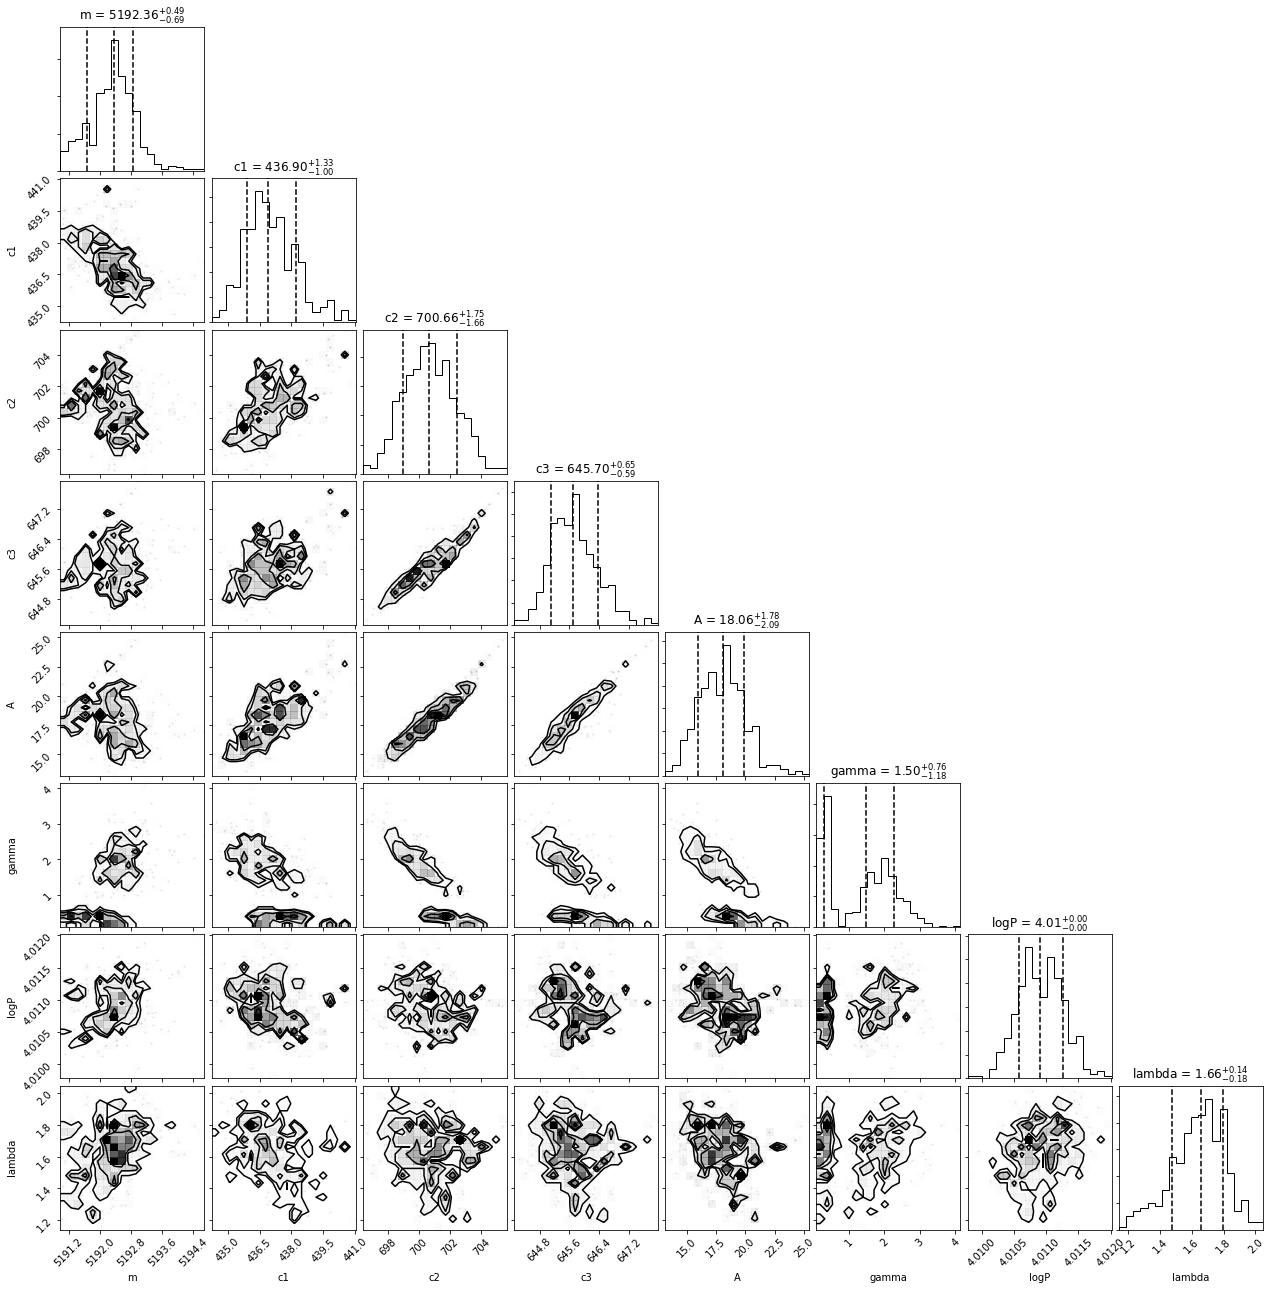

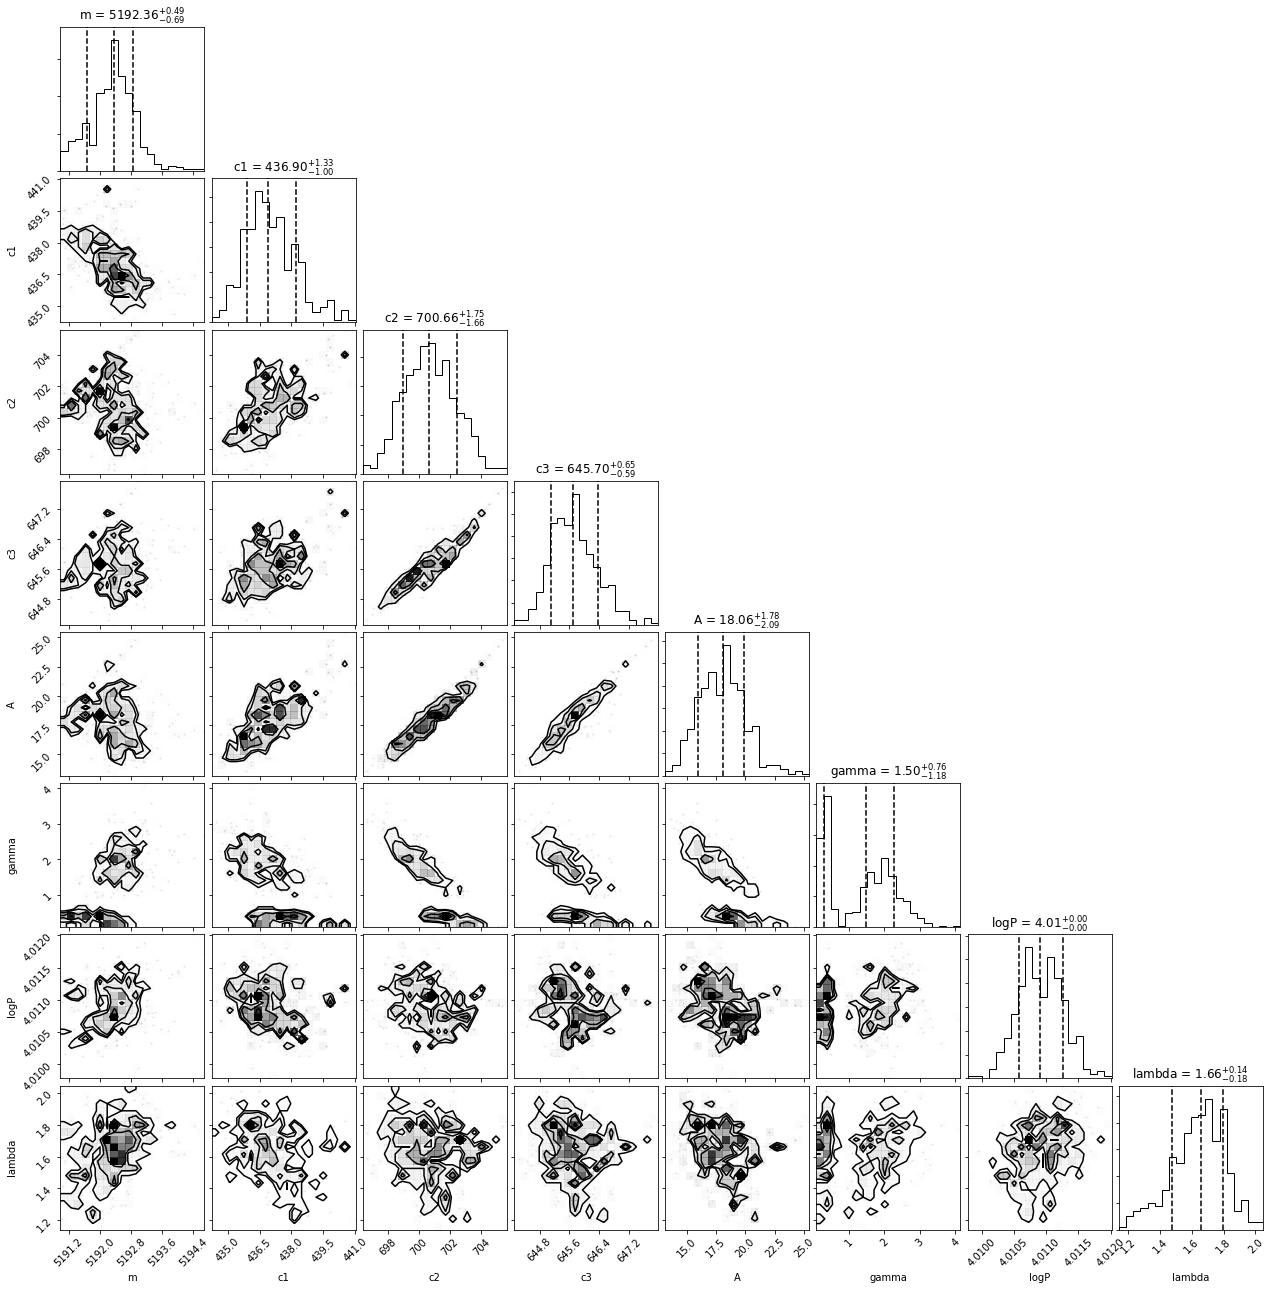

In [214]:
#every tenth sample, autocorrelation size =10
corner.corner(final_array[::10,:],labels=['m','c1','c2','c3','A','gamma','logP','lambda'],quantiles=[0.16, 0.5, 0.84],show_titles=True)

Text(0.5, 0, 'time')

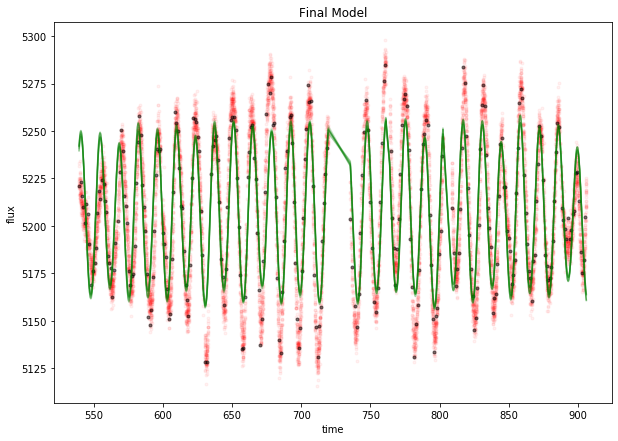

In [215]:
#correct samples; how to estimate
final_c1_2 = np.median(final_array[:,1])
final_c2_2 = np.median(final_array[:,2])
final_c3_2 = np.median(final_array[:,3])
def correct_2(t,y):
    correction_dict = {6:0,7:final_c1_2,8:final_c2_2 ,9:final_c3_2}
    quarter = np.vectorize(quarter_dict.get)(t)
    this = np.vectorize(correction_dict.get)(quarter)
    return(y-this)

corrected_y_2  = correct_2(t,y)

plt.figure(figsize=(10,7))

plt.plot(t, corrected_y_2 , "r.", alpha=0.05,label='all data')
plt.plot(t[::50], corrected_y_2 [::50], "k.",alpha=0.5,label='conditioned data')
#next plot 10 posterior samples
samples_2  = final_array
for s in samples_2 [np.random.randint(samples_2.shape[0], size=10)]:
    #s[6]+=0.3
    gp.set_parameter_vector(s)
    mu_2  = gp.predict(y[::50], t, return_cov=False)
    corrected_mu_2  = correct_2 (t,mu_2 )
    plt.plot(t,corrected_mu_2 ,color='g',alpha=0.2)    

plt.title('Final Model')
plt.ylabel('flux')
plt.xlabel('time')